In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
plt.style.use("customstyle")
import matplotlib.colors
import json
import sys
sys.path.append("../modules")

import PBD_analog

colors = ["#" + x for x in ["000000","cf5c36","bcd696","985f99","9684a1"]]

# Style for the plot
stl = {"ls": "", "marker":"o", "elinewidth":2, "markersize" : 5, "capsize" : 5}

width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
logNorm = matplotlib.colors.LogNorm(0.2, 8)
cmap = "Oranges"

In [2]:
# Load inference data
outdir = "C:/Users/pveron/Output_clusters/PBD_analog/12152"

simul_infer = pd.read_csv(outdir + "/all_simulations_inference.csv")
simul_infer["combinaison"] = 10*simul_infer.param_vary + simul_infer.i_param_var

summary_all_mcmc = pd.read_csv(outdir + "/summary_all_MCMC.csv")

n_rep = 1 + max(simul_infer.replicate)

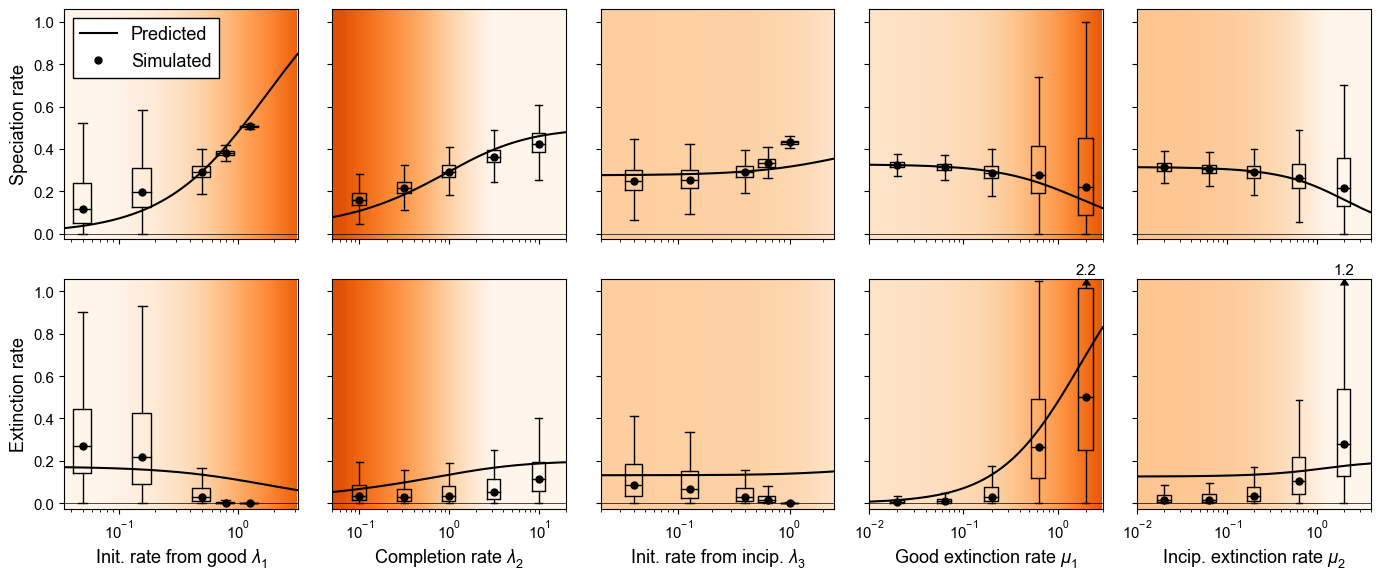

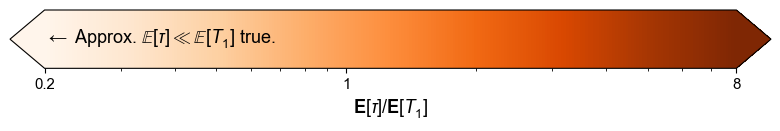

In [3]:
# Define ranges for the parameters 
#-- uncomment these lines for diversification + turnover rates
ranges = {'l1':(0.035, np.power(10,0.5) * 2 * 0.5),
          'l2':(0.05, 20),
          'l3':(0.02, np.power(10.0,0.5) * 2 * 0.4),
          'm1':(0.01, 3),
          'm2':(0.01, 4)}

burnin = 500

param_default = {'l1':0.5, 'l2':1.0, 'l3':0.4, 'm1':0.2, 'm2':0.2}
par_names = list(param_default.keys())
par_names_PBD = ["PBD." + s for s in ['l1','l2','l3', 'mu1', 'mu2']]

rate_names = ["l", "mu"]
#-- rate_names = ["l", "mu", "div", "turnov"]

xlabels = ["Init. rate from good $\\lambda_1$", "Completion rate $\\lambda_2$", "Init. rate from incip. $\\lambda_3$", "Good extinction rate $\\mu_1$", "Incip. extinction rate $\\mu_2$"]

fig, axes = plt.subplots(2,5, figsize = (14, 6), sharey="row", sharex="col")
#-- fig, axes = plt.subplots(4,5, figsize = (19, 15), sharey="row", sharex="col")


w = 0.15 # width of boxplots

for i in range(len(par_names)):
    par = par_names[i]
    param = param_default.copy()

    x = np.linspace(*ranges[par], 1000)
    # calculate predictions
    birth_pred, death_pred = np.zeros_like(x), np.zeros_like(x)
    T1, tau = np.zeros_like(x), np.zeros_like(x)    
    for j in range(len(x)):
        param[par] = x[j]
        birth_pred[j], death_pred[j] = PBD_analog.analog_BD_rates(**param)
        tau[j] = PBD_analog.tau(**param)
        T1[j] = PBD_analog.approx_expected_T(**param) - tau[j]

    
    im = np.array([tau / T1])

    axes[0,i].plot(x, birth_pred, color = colors[0], label = "Predicted")
    axes[1,i].plot(x, death_pred, color = colors[0])
    #-- axes[2,i].plot(x, birth_pred - death_pred, color = colors[0])
    #-- axes[3,i].plot(x, death_pred / birth_pred, color = colors[0])

    for j in range(len(rate_names)):
            extent = (x[0], x[-1], -10, 10)
            image = axes[j,i].imshow(im, cmap = cmap, norm = logNorm, 
                     aspect = 'auto', extent = extent)
    summary_par = summary_all_mcmc.loc[summary_all_mcmc.param_vary == i+1]


    # boxplot of posterior distributions 
    for k in range(len(rate_names)):
        r = rate_names[k]
        yerr = [summary_par["allMCMC."+r+".median"] - summary_par["allMCMC."+r+".q25"],
                summary_par["allMCMC."+r+".q75"] - summary_par["allMCMC."+r+".median"]]
        axes[k,i].plot(summary_par[par_names_PBD[i]], summary_par["allMCMC."+r+".median"], 
                       color = "k", label = "Simulated", ls = "",
                       marker = "o", markersize = 5)
        box_list = []
        for i_param_var in range(1, 1 + len(summary_par)):
        # load boxplot data
            with open(outdir + "/boxplot-"+r+"-par{}-var{}.json".format(i+1, i_param_var), 'r') as f:
                box = json.load(f)
                box["fliers"] = np.array(box["fliers"])
                box["label"]= None
                box_list.append(box)
        p = summary_par[par_names_PBD[i]]
        axes[k,i].bxp(box_list, positions = p, vert = True, widths = width(p, w), 
                      showfliers = False, medianprops = dict(color = "k"))

    axes[-1,i].set_xlabel(xlabels[i])
    axes[0,i].set_xscale("log")

    for k in range(len(rate_names)):
        axes[k, i].axhline(0, ls = "-", lw = 0.5)

# Manually add the markers out from the axis
axes[1,3].plot([2], [1.06], marker = 6, color = "k")
with open(outdir + "/boxplot-mu-par4-var5.json".format(i+1, i_param_var), 'r') as f:
    whishi = json.load(f)["whishi"]
axes[1,3].text(2, 1.08, "{:.2}".format(whishi), ha = "center", size = "small")


axes[1,4].plot([2], [1.06], marker = 6, color = "k")
with open(outdir + "/boxplot-mu-par5-var5.json".format(i+1, i_param_var), 'r') as f:
    whishi = json.load(f)["whishi"]
axes[1,4].text(2, 1.08, "{:.2}".format(whishi), ha = "center", size = "small")
# Set manually the ylim
axes[0,0].set_ylim(-0.025, 1.06) # speciation rate
axes[1,0].set_ylim(-0.025, 1.06) # extinction rate
#-- axes[2,0].set_ylim(-0.8, 0.8) # div rate
#-- axes[3,0].set_ylim(0, 10)  # turnover rate 

axes[0,0].set_ylabel("Speciation rate")
axes[1,0].set_ylabel("Extinction rate")
#-- axes[2,0].set_ylabel("Diversification rate")
#-- axes[3,0].set_ylabel("Turnover rate")


axes[0,0].legend()

plt.savefig("../fig/CBD_rates_from_PBD_simulations.pdf")

fig_cb, ax_cb = plt.subplots(figsize = (8, 1.5))
cbar = plt.colorbar(image, orientation = 'horizontal', 
             label = "$\\mathbf{E}[\\tau] / \\mathbf{E}[T_1]$",
             extend = "both", cax = ax_cb)
cbar.set_ticks(ticks = [0.2,1.0,8.0], labels=['0.2', '1', '8'])
ax_cb.text(0.2, 0.5, "$\\leftarrow$ Approx. $\\mathbb{E} [\\tau] \\ll \\mathbb{E} [T_1]$ true.", va = "center")

plt.savefig("../fig/CBD_rates_from_PBD_simulations-colorbar.pdf");

Compute some statistics

In [4]:
analog_BD_vect = np.vectorize(PBD_analog.analog_BD_rates)

df = summary_all_mcmc.copy()
b, d = analog_BD_vect(df["PBD.l1"], df["PBD.l2"], df["PBD.l3"], df["PBD.mu1"], df["PBD.mu2"])

df["equivBD.l"] = b
df["equivBD.mu"] = d
df["equivBD.div"] = b - d
df["equivBD.turnov"] = d / b

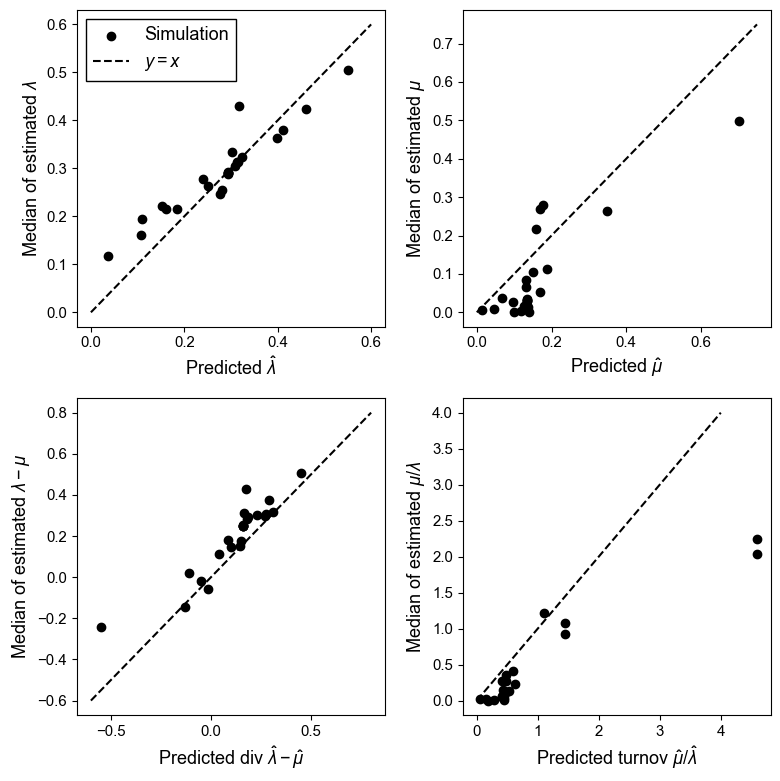

In [5]:
fig, axes = plt.subplots(2, 2, figsize = (8,8))

axes = axes.flatten()

axes[0].scatter(df["equivBD.l"], df["allMCMC.l.median"], label = "Simulation")
axes[0].plot([0,0.6], [0,0.6], ls  = "--", label = "$y = x$")
axes[0].set_xlabel("Predicted $\\hat{\\lambda}$")
axes[0].set_ylabel("Median of estimated $\\lambda$")
axes[0].legend()


axes[1].scatter(df["equivBD.mu"], df["allMCMC.mu.median"])
axes[1].plot([0,0.75], [0,0.75], ls  = "--")
axes[1].set_xlabel("Predicted $\\hat{\\mu}$")
axes[1].set_ylabel("Median of estimated $\\mu$")

axes[2].scatter(df["equivBD.div"], df["allMCMC.div.median"])
axes[2].plot([-0.6,0.8], [-0.6, 0.8], ls  = "--")
axes[2].set_xlabel("Predicted div $\\hat{\\lambda} - \\hat{\\mu}$")
axes[2].set_ylabel("Median of estimated $\\lambda - \\mu$")

axes[3].scatter(df["equivBD.turnov"], df["allMCMC.turnov.median"])
axes[3].plot([0,4], [0, 4], ls  = "--")
axes[3].set_xlabel("Predicted turnov $\\hat{\\mu} / \\hat{\\lambda}$")
axes[3].set_ylabel("Median of estimated $\\mu / \\lambda$");

In [6]:
print("-------- Difference in median birth rate --------")
err = df["allMCMC.l.median"] - df["equivBD.l"]
xp = df["equivBD.l"]
print("# estimated > predicted        : {} / {}".format(np.sum(err > 0), len(df)))
print("mean error                     : {:.3}".format(np.mean(err)))
print("standard dev on error          : {:.3}".format(np.std(err)))

print("mean absolute error            : {:.3}".format(np.mean(np.abs(err))))
print("standard dev on absolute error : {:.3}".format(np.std(np.abs(err))))

print("mean relative gap              : {:.1%}".format(np.mean(np.abs(err) / xp)))


print("\n\n")
print("-------- Difference in median death rate --------")
err = df["allMCMC.mu.median"] - df["equivBD.mu"]
xp = df["equivBD.mu"]
print("# estimated > predicted        : {} / {}".format(np.sum(err > 0), len(df)))
print("mean error                     : {:.3}".format(np.mean(err)))
print("standard dev on error          : {:.3}".format(np.std(err)))

print("mean absolute error            : {:.3}".format(np.mean(np.abs(err))))
print("standard dev on absolute error : {:.3}".format(np.std(np.abs(err))))

print("mean relative gap              : {:.1%}".format(np.mean(np.abs(err) / xp)))


-------- Difference in median birth rate --------
# estimated > predicted        : 11 / 25
mean error                     : 0.0137
standard dev on error          : 0.0417
mean absolute error            : 0.0318
standard dev on absolute error : 0.0302
mean relative gap              : 22.7%



-------- Difference in median death rate --------
# estimated > predicted        : 3 / 25
mean error                     : -0.0695
standard dev on error          : 0.07
mean absolute error            : 0.0905
standard dev on absolute error : 0.0393
mean relative gap              : 65.3%


In [7]:
print("-------- Difference in median diversification rate --------")
err = df["allMCMC.div.median"] - df["equivBD.div"]
xp = df["equivBD.div"]
print("# estimated > predicted        : {} / {}".format(np.sum(err > 0), len(df)))
print("mean error                     : {:.3}".format(np.mean(err)))
print("standard dev on error          : {:.3}".format(np.std(err)))

print("mean absolute error            : {:.3}".format(np.mean(np.abs(err))))
print("standard dev on absolute error : {:.3}".format(np.std(np.abs(err))))

print("mean relative gap              : {:.1%}".format(np.mean(np.abs(err / xp))))



print("\n\n")
print("-------- Difference in median turnover rate --------")
err = df["allMCMC.turnov.median"] - df["equivBD.turnov"]
xp = df["equivBD.turnov"]
print("# estimated > predicted        : {} / {}".format(np.sum(err > 0), len(df)))
print("mean error                     : {:.3}".format(np.mean(err)))
print("standard dev on error          : {:.3}".format(np.std(err)))

print("mean absolute error            : {:.3}".format(np.mean(np.abs(err))))
print("standard dev on absolute error : {:.3}".format(np.std(np.abs(err))))

print("mean relative gap              : {:.1%}".format(np.mean(np.abs(err) / xp)))

-------- Difference in median diversification rate --------
# estimated > predicted        : 23 / 25
mean error                     : 0.0802
standard dev on error          : 0.0735
mean absolute error            : 0.0842
standard dev on absolute error : 0.0688
mean relative gap              : 63.4%



-------- Difference in median turnover rate --------
# estimated > predicted        : 1 / 25
mean error                     : -0.452
standard dev on error          : 0.609
mean absolute error            : 0.462
standard dev on absolute error : 0.601
mean relative gap              : 63.7%
